# Building a Bert-Classifier for Hatespeech Classification

In this notebook we build a hate speech classifier based on the data presented in 'Automated Hate Speech Detection and the Problem of Offensive Language' by Davison et al. in 2ß18. The classifier consists of a fully connected layer ont top of a BERT model.

The implemenation is based on:
- https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
- https://xiangyutang2.github.io/tweet-classification/
- https://github.com/t-davidson/hate-speech-and-offensive-language

## Loading all needed Libraries

In [ ]:
! pip install transformers==3
! pip install tokenizers==0.7.0

     |████████████████████████████████| 757kB 8.7MB/s 
     |████████████████████████████████| 3.0MB 18.2MB/s 
     |████████████████████████████████| 890kB 47.7MB/s 
     |████████████████████████████████| 1.2MB 57.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=1f42029f2eb655b45d1870267c2ae16594bddcc70d63537bb90fd0b5f9a76b0f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 5.6MB 8.2MB/s 
ERROR: transformers 3.0.0 has requirement tokenizers==0.8.0-rc4, but you'll have tokenizers 0.7.0 which is incompatible.
  Found existing installation: tokenizers 0.8.0rc4
    Uninstalling tokenizers-0.8.0rc4:
      Successfully uninstalled tokenizers-0.8.0rc4


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from google.colab import drive
drive.mount('/content/gdrive')

- Get GPU

In [ ]:
# Get Device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Used device is {device}')

Used device is cuda:0


- Next we create two folders to save models and data in 


In [ ]:
# Setting up folder to save data and models
! mkdir data
! mkdir models

## Data Exploration and Preprocessing

- Upload data in csv format

In [ ]:
# Loading Data 
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


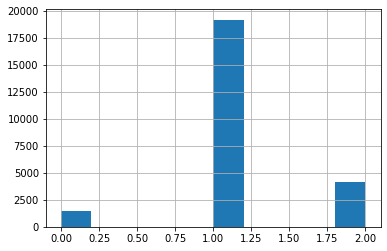

In [ ]:
# Data class distributions
df['class'].hist()

 - We slightly alter prerpocess fucntion from origianl code. Using casual tokenizer from nltk does eitehr keep or remove handles/URLs completely
 We aim to have mentions and links as information for the model. However, as no metadata about users is used, it does not matter who is addressed.
 Thus, replacing all handles and URLs by respective representations will help the model understand better if someone was addressed or not. 

In [ ]:
def anonymize_users_and_links(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URL', parsed_text)
    parsed_text = re.sub(mention_regex, 'USER', parsed_text)
    parsed_text = re.sub('RT', '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

In [ ]:
# Processing Tweets
df['tweet'] = [anonymize_users_and_links(tweet) for tweet in df['tweet']]
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! USER: As a woman you shouldn't complain a...
1,1,3,0,3,0,1,!!!!! USER: boy dats cold...tyga dwn bad for ...
2,2,3,0,3,0,1,!!!!!!! USER Dawg!!!! USER: You ever fuck a ...
3,3,3,0,2,1,1,!!!!!!!!! USER: USER she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! USER: The shit you hear about m...


## Building Bert Classifier Model

### Bert specific processing

In [ ]:
# Special BERT mdoe to be used: While slight information might be lost; capitalization in tweets is a neglectable characteristic
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

- Get understanding of the distribution of token sizes for maximal lanrgth used in BERT

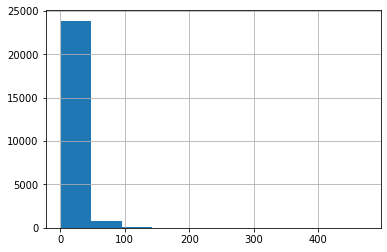

In [ ]:
df['len'] = [len(tokenizer.tokenize(tweet)) for tweet in df['tweet']]
df['len'].hist() 

### Build PyTorch Dataset and DataLoader

In [ ]:
# Data Structure
class TweetsDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = tokenizer(tweet,
                             truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = 'max_length',
                             max_length=self.max_len,
                             return_attention_mask=True,
                             return_tensors='pt')
      
        return { 'tweet': tweet, 'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
        }
# Data Loader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetsDataset(
        tweets=df['tweet'].to_numpy(),
        labels=df['class'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

### Actual Model

In [ ]:
class HSClassifier(nn.Module):
    def __init__(self, n_classes):
        
        super(HSClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

## Training the model

### Define Helper functions

In [ ]:
# This provides just awuik way to illustrate our confusion matrices in a nice and labeled way
def show_confusion_matrix(confusion_matrix):
  names=['Hate','Offensive','Neither']
  confusion_df = pd.DataFrame(cm, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)
  plt.savefig(f'/content/gdrive/My Drive/HS/data/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_Batchsize{BATCH_SIZE}_confusionmatrix.png')
  plt.show()

In [ ]:
def get_predictions(model, data_loader):
  # put to eval mode to disable dropout 
  model = model.eval()

  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask) #dim BATCH_SIZE x 3
      # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
      _, preds = torch.max(outputs, dim=1) # dim BATCH_SIZE x 1

      predictions.extend(preds)
      #prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  #prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values #prediction_probs

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    model = model.train()
    losses = []
    correct_predictions = 0
    
    show_every = np.floor(len(data_loader)/5)
    
    for i,d in enumerate(data_loader):
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
        _, preds = torch.max(outputs, dim=1)
        
        loss = loss_fn(outputs, labels) # both outputs and labels are in {0,1,2}
        correct_predictions += torch.sum(preds == labels)
        
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
                
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def get_weights(df, exponent = 1):
    # original balanced weights
    class_weights_balanced = dict(zip([0,1,2],[len(df)/(3*sum(df['class']==i)) for i in range(3)]))

    # Expoentially weighted
    Z = sum(val**exponent for key,val in class_weights_balanced.items())
    class_weights_dict= dict(zip([0,1,2],[(val**exponent)/Z for key,val in class_weights_balanced.items()]))

    # To tensor
    class_weights = torch.tensor([ value for value in class_weights_dict.values()]) 

    return class_weights 

### Parameter choices
- Set hyper parameters and run optimization accordingly

In [ ]:
MAX_LEN = 100 # chosen acccroding to hist above
BATCH_SIZE = 16 # tunable hyper parameter
EPOCHS = 6
EXPONENT = 1
lr = 2e-5
NAME ='BERT'

### Optimization


- Prepare data

In [ ]:
# Splitting data
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 42) 
df_val, df_test = train_test_split(df_test, test_size=0.5,random_state = 42) 

# Create DataLoaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

- Initialize model


In [ ]:
# Initialize model
model = HSClassifier(3).to(device)

- Set everything optimization related



In [ ]:
#Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps= len(train_data_loader) * EPOCHS
)

#Weights 
class_weights = get_weights(df_train, exponent=EXPONENT)
print('Class weights: ', class_weights)

# The choice of loss is done, as 'This criterion combines LogSoftmax and NLLLoss in one single class'. 
# given input vector softmay is applied, and then NLLL  loss performed
loss_fn = nn.CrossEntropyLoss(weight = class_weights).to(device)

Class weights:  tensor([0.7058, 0.0524, 0.2418])


- Actual optimization procedure

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
      
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
      
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        print(f'Model updated after epoch: {epoch+1} \n')
        torch.save(model.state_dict(), f'models/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_BatchSize{BATCH_SIZE}_best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/6
----------
Train loss 0.5995781219113738 accuracy 0.8636638757187531
Val   loss 0.5197426372237743 accuracy 0.9011299435028248

Model updated after epoch: 1 

Epoch 2/6
----------
Train loss 0.4546806253214938 accuracy 0.915514980328861
Val   loss 0.5852200793222554 accuracy 0.9019370460048426

Model updated after epoch: 2 

Epoch 3/6
----------
Train loss 0.36721041593268783 accuracy 0.936094017956219
Val   loss 0.7145044223916146 accuracy 0.9047619047619048

Model updated after epoch: 3 

Epoch 4/6
----------
Train loss 0.2933099114307908 accuracy 0.9578835872087158
Val   loss 0.9436980706158905 accuracy 0.9027441485068604

Epoch 5/6
----------
Train loss 0.2405030589799055 accuracy 0.9683244224755371
Val   loss 1.133784377008992 accuracy 0.9075867635189668

Model updated after epoch: 5 

Epoch 6/6
----------


## Model Evaluation

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
#plt.yscale('log')
plt.show()

- Next we load our best model, as the current state might have overfitted

In [ ]:
# load best model from optimization
model = HSClassifier(3)
model.load_state_dict(torch.load(f'models/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_BatchSize{BATCH_SIZE}_best_model_state.bin'))
model = model.to(device)

In [ ]:
# Test Accuracy
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test Accuracy: {test_acc.item()}')

- Calculate Scores 

In [ ]:
# Calculation of relevant scores
y_pred, y_test = get_predictions(model, test_data_loader)
report = classification_report(y_test, y_pred, target_names=['HS', 'OL', 'NE'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f'/content/gdrive/My Drive/HS/data/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_BatchSize{BATCH_SIZE}_Report.csv') 

report_df

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
show_confusion_matrix(cm)

In [ ]:
#from google.colab import files
#files.download("data")
#files.download("mdodels")

In [ ]:
model_save_name = f'models/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_BatchSize{BATCH_SIZE}_best_model_state.bin'
path = f"/content/gdrive/My Drive/HS/{model_save_name}" 
torch.save(model.state_dict(), path)